Загрузимо та продемонструємо датасет

In [1]:
import pandas as pd

df = pd.read_csv('Iris.csv')
print(df.head())

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


Перетворимо числові оснаки на категоріальні та розіб'ємо їх на категорії та створимо транзакції

In [2]:
df['sepal_length_bin'] = pd.qcut(df['SepalLengthCm'], q=3, labels=['short', 'medium', 'long'])
df['sepal_width_bin']  = pd.qcut(df['SepalWidthCm'],  q=3, labels=['narrow', 'medium', 'wide'])
df['petal_length_bin'] = pd.qcut(df['PetalLengthCm'], q=3, labels=['short', 'medium', 'long'])
df['petal_width_bin']  = pd.qcut(df['PetalWidthCm'],  q=3, labels=['thin', 'medium', 'thick'])

transactions = df[['sepal_length_bin', 'sepal_width_bin', 'petal_length_bin', 'petal_width_bin']].astype(str).values.tolist()

transaction_list = []
for row in transactions:
    transaction_list.append([
        f'sepal_length={row[0]}',
        f'sepal_width={row[1]}',
        f'petal_length={row[2]}',
        f'petal_width={row[3]}'
    ])

In [3]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Encode
te = TransactionEncoder()
te_ary = te.fit(transaction_list).transform(transaction_list)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apriori
frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

print("\nAssociation Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Association Rules:
                                          antecedents  \
0                                 (petal_width=thick)   
1                                 (petal_length=long)   
2                                 (sepal_length=long)   
3                                (petal_width=medium)   
4                               (petal_length=medium)   
..                                                ...   
72  (sepal_length=short, petal_width=thin, sepal_w...   
73  (petal_length=short, sepal_length=short, sepal...   
74               (petal_width=thin, sepal_width=wide)   
75             (petal_length=short, sepal_width=wide)   
76             (sepal_length=short, sepal_width=wide)   

                                 consequents   support  confidence      lift  
0                        (petal_length=long)  0.273333    0.854167  2.785326  
1                        (petal_width=thick)  0.273333    0.891304  2.785326  
2                        (petal_length=long)  0.213333    

Кластеризація та порівняльний аналіз методів

In [4]:
!pip install scikit-learn-extra

In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=Warning)

X = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

methods = {}

# k-Means
kmeans = KMeans(n_clusters=3, random_state=42)
methods['k-Means'] = kmeans.fit_predict(X_scaled)

# k-Medians 
kmedians = KMedoids(n_clusters=3, metric='manhattan', random_state=42)
methods['k-Medians'] = kmedians.fit_predict(X_scaled)

# Closest Neighbour (Hierarchical single linkage)
linked = linkage(X_scaled, method='single')
methods['Closest Neighbour'] = fcluster(linked, t=3, criterion='maxclust')

# DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=5)
methods['DBSCAN'] = dbscan.fit_predict(X_scaled)

results = {}

for name, labels in methods.items():
    labels = np.array(labels)  # Конвертуємо в numpy-масив для коректної логіки
    
    if -1 in labels:
        mask = labels != -1  # Виключаємо шуми DBSCAN
    else:
        mask = np.array([True]*len(labels))
    
    # Перевіряємо, чи залишилось достатньо точок для оцінки
    if np.sum(mask) > 1 and len(np.unique(labels[mask])) > 1:
        sil_score = silhouette_score(X_scaled[mask], labels[mask])
        db_score = davies_bouldin_score(X_scaled[mask], labels[mask])
        ch_score = calinski_harabasz_score(X_scaled[mask], labels[mask])
    else:
        sil_score = None
        db_score = None
        ch_score = None
    
    results[name] = {
        'Silhouette Score': sil_score,
        'Davies-Bouldin Index': db_score,
        'Calinski-Harabasz Index': ch_score
    }

# --- Вивід результатів ---
df_results = pd.DataFrame(results).T
print(df_results)

                   Silhouette Score  Davies-Bouldin Index  \
k-Means                    0.478724              0.786801   
k-Medians                  0.448710              0.832635   
Closest Neighbour          0.502877              0.496079   
DBSCAN                     0.610388              0.548314   

                   Calinski-Harabasz Index  
k-Means                         156.143038  
k-Medians                       235.412643  
Closest Neighbour               130.190988  
DBSCAN                          297.926559  


C:\Users\Vow\anaconda3\Lib\site-packages\sklearn_extra\cluster\_commonnn.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.23.0"):
C:\Users\Vow\anaconda3\Lib\site-packages\sklearn_extra\cluster\_commonnn.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.23.0"):


Візуалізуємо результати кластеризації

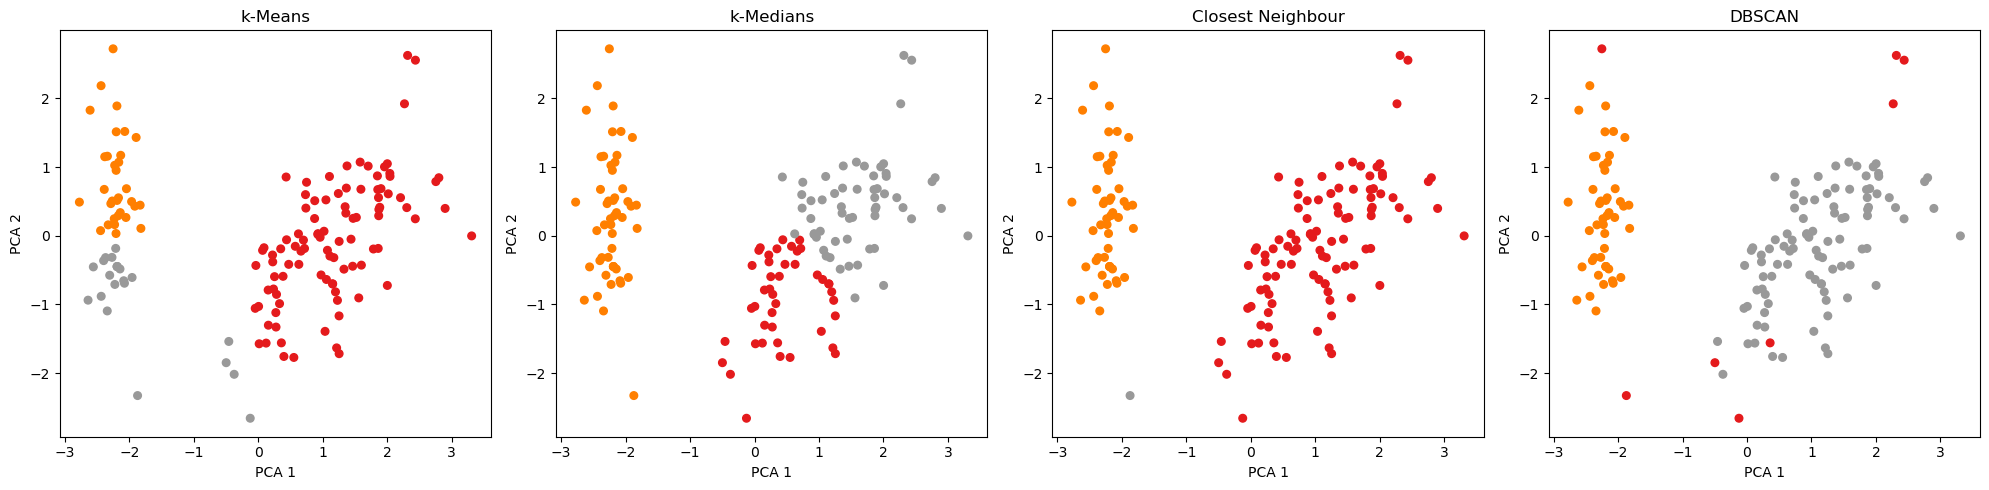

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Зниження розмірності до 2D для візуалізації
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

# Кількість методів
n_methods = len(methods)

# Побудова підграфіків
fig, axes = plt.subplots(1, n_methods, figsize=(5 * n_methods, 5))

if n_methods == 1:
    axes = [axes]

for ax, (name, labels) in zip(axes, methods.items()):
    ax.set_title(name)
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='Set1', s=30)
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')

plt.tight_layout()
plt.show()

DBSCAN — найкращий метод для цієї задачі: стабільні метрики, природне виявлення шуму, гарне візуальне розділення.

Closest Neighbour — також добре справляється, але потенційно чутливий до шуму та спотворень.

k-Means — добре працює при припущенні про сферичні кластери, але трохи поступається за метриками.

k-Medians — менш стабільний результат порівняно з іншими методами, хоча іноді краще справляється з викидами.